# Mass Profile

An extension of Homework 5.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Mass-profiles-by-particle-type" data-toc-modified-id="Mass-profiles-by-particle-type-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mass profiles by particle type</a></span></li><li><span><a href="#Hernquist-profiles" data-toc-modified-id="Hernquist-profiles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hernquist profiles</a></span></li><li><span><a href="#Rotation-curves" data-toc-modified-id="Rotation-curves-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Rotation curves</a></span></li><li><span><a href="#Final-timepoint" data-toc-modified-id="Final-timepoint-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final timepoint</a></span></li><li><span><a href="#Hernquist-profiles" data-toc-modified-id="Hernquist-profiles-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Hernquist profiles</a></span></li><li><span><a href="#Virial-radius" data-toc-modified-id="Virial-radius-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Virial radius</a></span></li><li><span><a href="#Polar-coordinates" data-toc-modified-id="Polar-coordinates-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Polar coordinates</a></span></li></ul></div>

## Setup

In [1]:
# scientific package imports
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import astropy.units as u
from astropy.constants import G

# import my own classes
from galaxy.galaxy import Galaxy
from galaxy.galaxies import Galaxies
from galaxy.massprofile import MassProfile
from galaxy.timecourse import TimeCourse
from galaxy.centerofmass import CenterOfMass
from galaxy.plots import Plots

Function to get the data for a chosen snap:

In [2]:
def get_mass_profiles(snap):
    g = Galaxies(snaps=snap, usesql=True)

    names = g.filenames
    mass_profiles = [(gname, MassProfile(g.galaxies[gname])) for gname in names]

    t = g.time.value / 1000
    
    # a dictionary to gather the scale radius
    fitted_a = {}

    # loop over galaxies
    for mass_prof in mass_profiles:
        gname, mp = mass_prof
        fitted_a[gname] = mp.fit_hernquist_a()
        
    return mass_profiles, t, fitted_a

## Mass profiles by particle type

In [3]:
p = Plots()
radii = np.linspace(0.1, 30) * u.kpc

In [4]:
snap = 0
mass_profiles, t, fitted_a = get_mass_profiles(snap)

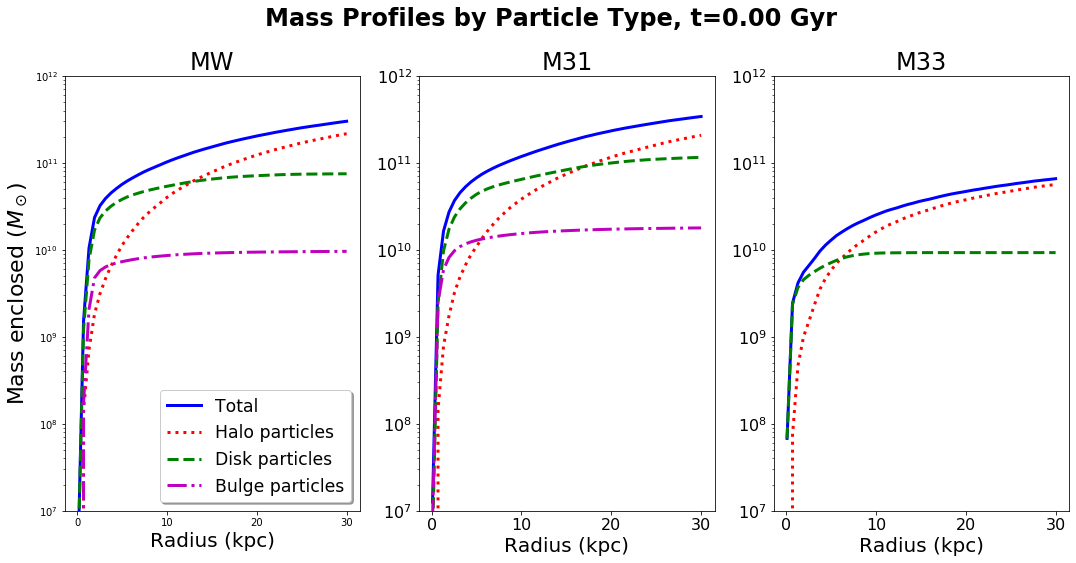

In [5]:
radii = np.linspace(0.1, 30) * u.kpc
p.mass_profiles(radii, mass_profiles, t, pngout=True, fname=f"massprof_{snap:03}.pdf")

## Hernquist profiles

In [6]:
for k, v in fitted_a.items():
    print(f'{k:8s}: a = {v}')

MW_000  : a = 61.1 kpc
M31_000 : a = 61.1 kpc
M33_000 : a = 24.3 kpc


## Rotation curves

Plot the three galaxies, with all axes matching:

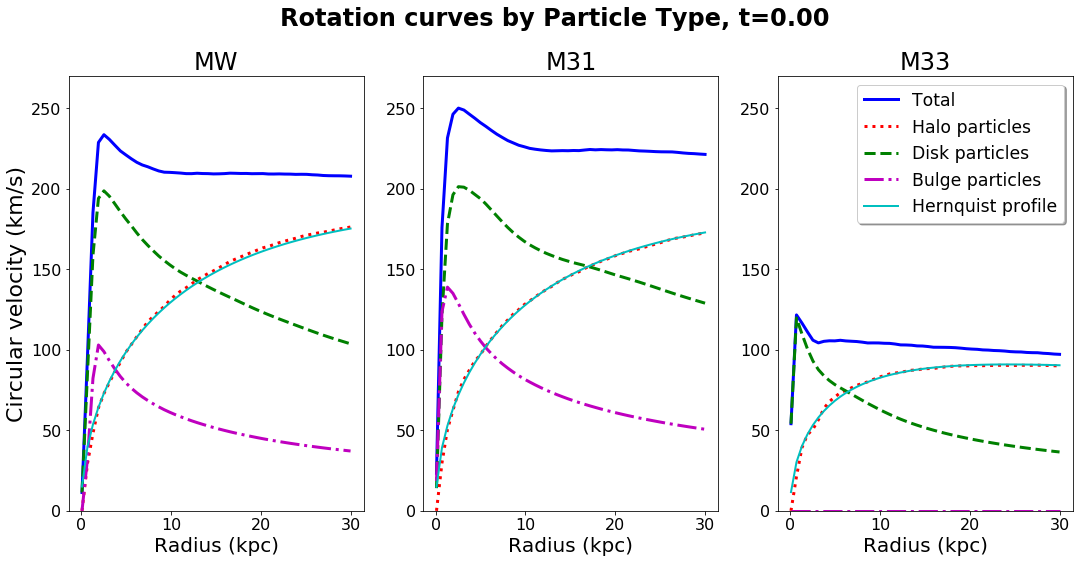

In [7]:
radii = np.linspace(0.1, 30) * u.kpc
p.rotation_curves(radii, mass_profiles, fitted_a, t, pngout=True, fname=f'rotcurve_{snap:03}.pdf')

## Final timepoint

In [8]:
mass_profiles, t, fitted_a = get_mass_profiles(801)

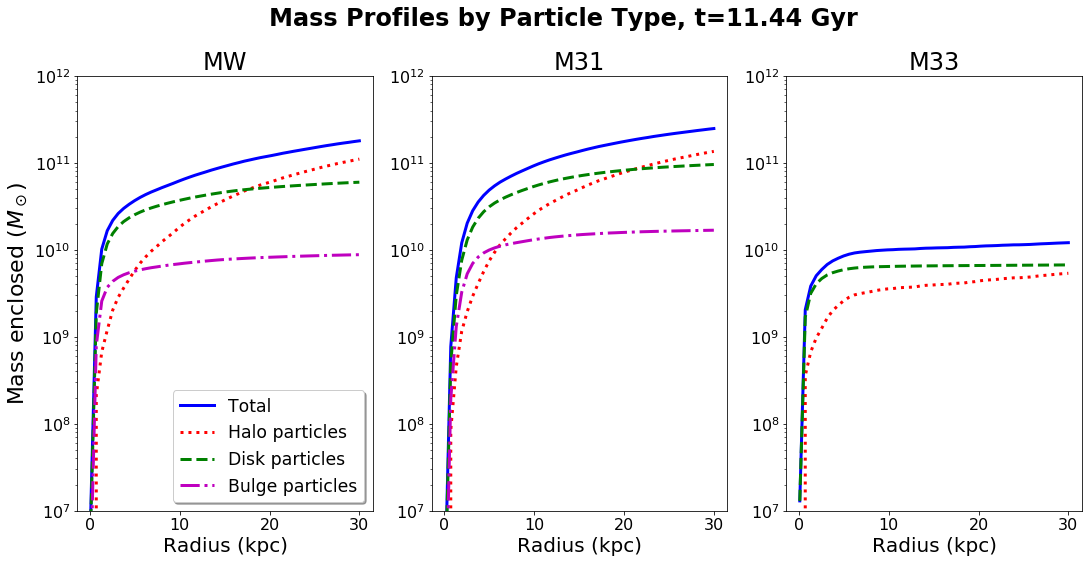

In [9]:
p.mass_profiles(radii, mass_profiles, t)

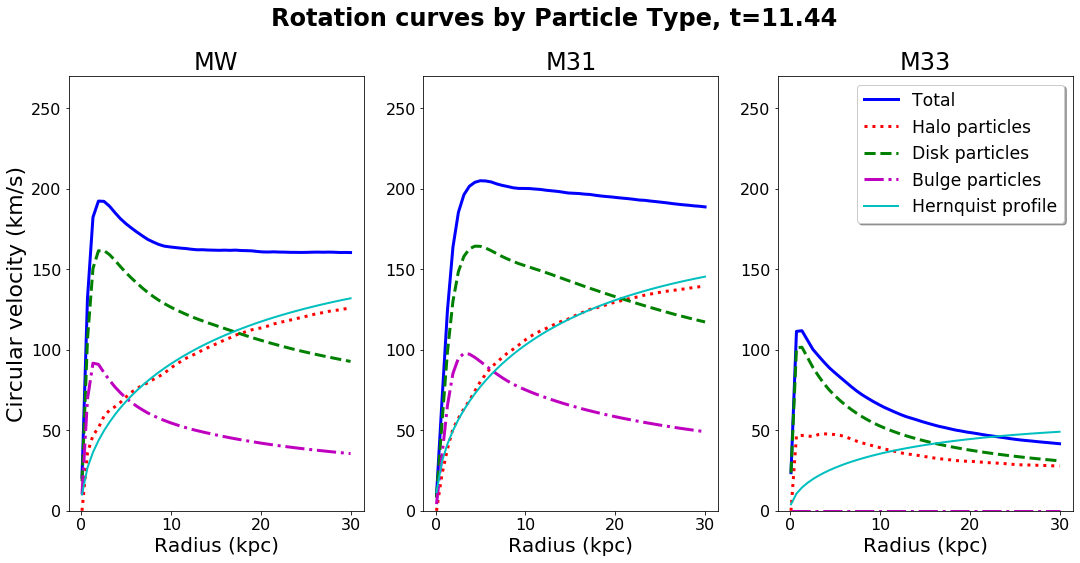

In [10]:
p.rotation_curves(radii, mass_profiles, fitted_a, t)

In [11]:
gname = 'M31'
snap = 100
M31 = Galaxy(gname, snap=snap, usesql=True)

## Hernquist profiles

In [12]:
galname = 'MW'
snap = 0
gal = Galaxy(galname, snap, usesql=True)

In [13]:
tc = TimeCourse(usesql=True)
com_p, _ = tc.get_one_com(galname, snap)
mp = MassProfile(gal, com_p)

In [17]:
fitted_a, perr = mp.fit_hernquist_a(get_details=True)
fitted_a, perr

(<Quantity 61.1 kpc>, <Quantity 0.4 kpc>)

## Virial radius

In [27]:
snap = 0
for galname in ('MW','M31','M33'):
    gal = Galaxy(galname, snap, usesql=True)
    com_p, _ = tc.get_one_com(galname, snap)
    mp = MassProfile(gal, com_p)
    r_200 = mp.virial_radius()
    m_200 = mp.virial_mass(r_200=r_200)
    print(galname, r_200, m_200)

MW 226.83417085427135 [1.317848e+12] solMass
M31 221.90954773869345 [1.3239474e+12] solMass
M33 103.71859296482411 [1.32083925e+11] solMass


In [28]:
227*2**(1/3)

286.0020783261362

## Polar coordinates

In [18]:
M31_com = CenterOfMass(M31)

In [19]:
tc = TimeCourse(usesql=True)
com_xyz, com_vxyz = tc.get_one_com(gname, snap)

# determine the rotated velocity vectors
rn, vn = M31_com.rotate_frame(com_p=com_xyz, com_v=com_vxyz)

In [20]:
rn.shape, vn.shape

((3, 600000), (3, 600000))

In [21]:
x,y,z = rn
xy = np.column_stack([x,y])
xy.shape

(600000, 2)

In [22]:
r = norm(xy, axis=1)
r.shape

(600000,)

In [23]:
theta = np.arctan2(y, x) * 180 / np.pi
theta.shape

(600000,)

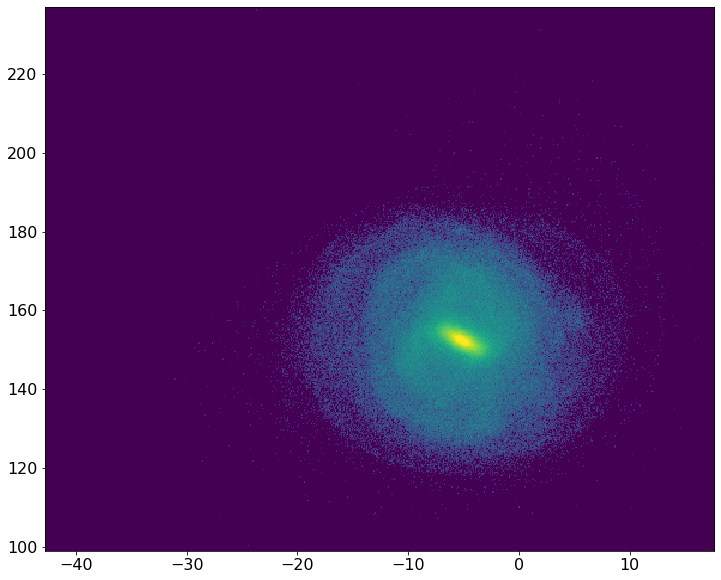

In [25]:
import mpl_scatter_density

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
imnorm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

# Make the plot in the (almost) usual pyplot way
# Note the projection to invoke mpl_scatter_density
#  and the norm to use LogStretch

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(theta, r, norm=imnorm)
# ax.set_ylim(0, 15)